In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/My\Drive/HumorDetection

In [ ]:
!pip install transformers 

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords, wordnet
from tqdm.notebook import tqdm
import string
import re
import math
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from nltk.stem import WordNetLemmatizer
from keras.models import Sequential, Model
from keras.layers import Embedding, LSTM, GRU, Conv1D, Dense, Input, Bidirectional, Dropout, SpatialDropout1D, MaxPooling1D, Flatten, BatchNormalization
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import TFBertModel, TFAlbertModel, TFRobertaModel, BertTokenizerFast, AlbertTokenizerFast, RobertaTokenizerFast
from sklearn.metrics import *
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

**Data preparation**

In [ ]:
train_data = pd.read_csv('train.csv') 
dev_data = pd.read_csv('dev.csv')
test_data = pd.read_csv('test.csv')

In [ ]:
display(train_data)

,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,1,TENNESSEE: We're the best state. Nobody even c...,1,2.42,1.0,0.20
1,2,A man inserted an advertisement in the classif...,1,2.50,1.0,1.10
2,3,How many men does it take to open a can of bee...,1,1.95,0.0,2.40
3,4,Told my mom I hit 1200 Twitter followers. She ...,1,2.11,1.0,0.00
4,5,Roses are dead. Love is fake. Weddings are bas...,1,2.78,0.0,0.10
...,...,...,...,...,...,...
7995,7996,Lack of awareness of the pervasiveness of raci...,0,NaN,NaN,0.25
7996,7997,Why are aspirins white? Because they work sorry,1,1.33,0.0,3.85
7997,7998,"Today, we Americans celebrate our independence...",1,2.55,0.0,0.00
7998,7999,How to keep the flies off the bride at an Ital...,1,1.00,0.0,3.00


In [ ]:
train_data[['is_humor', 'humor_rating', 'humor_controversy', 'offense_rating']].describe()

,is_humor,humor_rating,humor_controversy,offense_rating
count,8000.000000,4932.000000,4932.000000,8000.000000
mean,0.616500,2.260525,0.499797,0.585325
std,0.486269,0.566974,0.500051,0.979955
min,0.000000,0.100000,0.000000,0.000000
25%,0.000000,1.890000,0.000000,0.000000
50%,1.000000,2.280000,0.000000,0.100000
75%,1.000000,2.650000,1.000000,0.700000
max,1.000000,4.000000,1.000000,4.850000


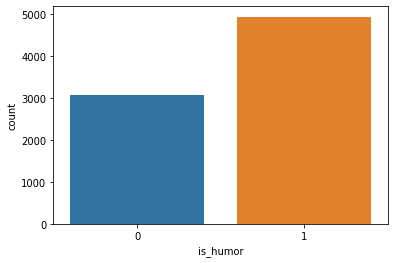

In [ ]:
sns.countplot(x='is_humor', data=train_data)

In the training data set, we can see that there are 4932 humorous texts out of 8000 total, which is more than a half.

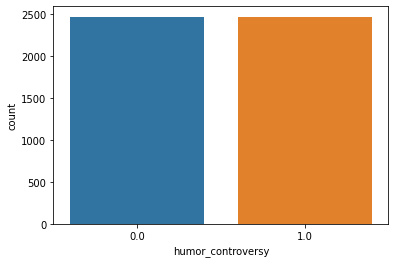

In [ ]:
sns.countplot(x='humor_controversy', data=train_data)

We can observe an equal amount of controversial and non-controversial texts among those that were found to be humorous.

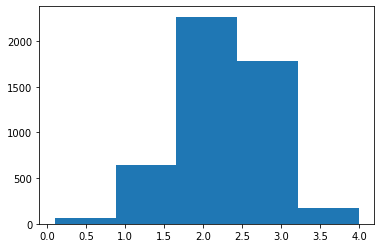

In [ ]:
# Distribution of humor rating in the data set
humor_ratings = train_data['humor_rating'].values
plt.hist(humor_ratings, bins=5)
plt.show()

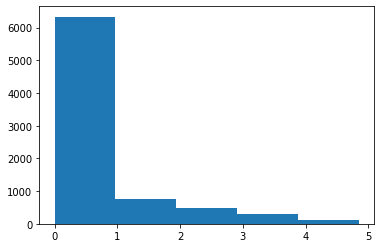

In [ ]:
# Distribution of offense rating in the data set
offense_ratings = train_data['offense_rating'].values
plt.hist(offense_ratings, bins=5)
plt.show()

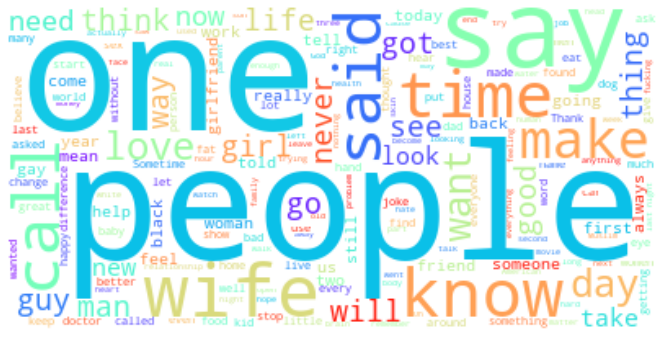

In [ ]:
plt.figure(figsize=(12, 6))
wc = WordCloud(colormap="rainbow", background_color="white").generate(" ".join(train_data['text']))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
display(dev_data)

,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,8001,What's the difference between a Bernie Sanders...,1,2.45,0.0,1.70
1,8002,"Vodka, whisky, tequila. I'm calling the shots.",1,2.00,0.0,0.00
2,8003,French people don't masturbate They Jacque off,1,2.95,0.0,1.15
3,8004,A lot of Suicide bombers are Muslims - I don't...,1,1.38,0.0,3.75
4,8005,What happens when you fingerbang a gypsy on he...,1,2.70,1.0,2.25
...,...,...,...,...,...,...
995,8996,boss: what are you doing inventor of the bagpi...,1,2.06,1.0,0.25
996,8997,I told him his views were pretty extreme and i...,0,NaN,NaN,0.10
997,8998,"""Mum, all the black kids call each other Nigga...",1,1.94,0.0,2.95
998,8999,"In honor of Fathers Day, I'm gonna bring you ""...",0,NaN,NaN,0.00


In [ ]:
display(test_data)

,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,9001,Finding out your ex got fat is like finding 20...,1,2.20,0.0,0.90
1,9002,"For Brockmann, stereotypes imperil national se...",0,NaN,NaN,0.35
2,9003,A girl runs up to her mother with a pile of cr...,1,2.80,1.0,0.10
3,9004,gotta wonder if baseball still would've been c...,1,2.15,0.0,0.00
4,9005,When you're dreading getting in the shower cuz...,1,2.25,0.0,0.35
...,...,...,...,...,...,...
995,9996,What do you call a black man on the moon? An a...,1,1.88,1.0,1.05
996,9997,when im picking someone up and they ask how lo...,1,1.88,0.0,0.00
997,9998,"A black lesbian, an obese white neck-beard, an...",1,1.80,1.0,1.65
998,9999,and I recognize the need to use ALL of my plat...,0,NaN,NaN,0.00


In [ ]:
def preprocess_text(text):
  """
  This function receives texts and returns clean word-list
  """
  # convert to lower case
  text = text.lower()
  # cleaning: non-ASCII filtering, appostrophes etc.
  text = re.sub(r"’", r"'", text)
  text = re.sub(r",", " ", text)
  text = re.sub(r"\.", " ", text)
  text = re.sub(r"!", " ", text)
  text = re.sub(r"\/", " ", text)
  text = re.sub(r"\^", " ", text)
  text = re.sub(r"\+", " ", text)
  text = re.sub(r"\*", "", text)
  text = re.sub(r"\-", " ", text)
  text = re.sub(r"\=", " ", text)
  text = re.sub(r":", " ", text)
  text = re.sub(r";", " ", text)
  text = re.sub(r"\"", " ", text)
  text = re.sub(r"“", " ", text)
  text = re.sub(r"\&", " ", text)
  text = re.sub(r"\?", " ", text)
  text = re.sub(r"\(", " ", text)
  text = re.sub(r"\)", " ", text)
  text = re.sub(r"-", " ", text)
  text = re.sub(r"”", " ", text)
  text = re.sub(r"%", " ", text)
  text = re.sub(r"‘", "'", text)
  text = re.sub(r"@", " ", text)
  text = re.sub(r"\$", " ", text)
  text = re.sub(r"–", " ", text)
  text = re.sub(r"£", " ", text)
  text = re.sub(r"{", " ", text)
  text = re.sub(r"}", " ", text)
  text = re.sub(r"・", " ", text)
  text = re.sub(r"\.{3}", " ", text)
  text = re.sub(r"„", " ", text)
  text = re.sub(r"\s{2,}", " ", text)

  tokenizer = TweetTokenizer()
  words = tokenizer.tokenize(text)

  contractions = {"aren't": "are not", "can't": "cannot", "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not",
                  "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'll": "he will", "he's": "he is",
                  "i'd": "i would", "i'll": "i will", "i'm": "i am", "isn't": "is not", "it's": "it is", "it'll": "it will",
                  "i've": "i have", "let's": "let us", "mightn't": "might not", "mustn't": "must not", "shan't": "shall not", "she'd": "she would",
                  "she'll": "she will", "she's": "she is", "shouldn't": "should not", "that's": "that is", "there's": "there is", "they'd": "they would",
                  "they'll": "they will", "they're": "they are", "they've": "they have", "we'd": "we would", "we're": "we are", "weren't": "were not",
                  "we've": "we have", "what'll": "what will", "what're": "what are", "what's": "what is", "what've": "what have", "where's": "where is",
                  "who'd": "who would", "who'll": "who will", "who're": "who are", "who's": "who is", "who've": "who have", "won't": "will not",
                  "wouldn't": "would not", "you'd": "you would", "you'll": "you will", "you're": "you are", "you've": "you have", "'re": " are",
                  "wasn't": "was not", "we'll": "we will"}
  words = [contractions[word] if word in contractions else word for word in words]

  clean_text = " ".join(words)
  clean_text = re.sub("  ", " ", clean_text)
  return clean_text

In [ ]:
def calculate_metrics_classification(y_test, y_predicted):
  print(classification_report(y_test, y_predicted))
  plt.figure(figsize=(7,7))
  sns.heatmap(confusion_matrix(y_test, y_predicted), annot=True, fmt='.5g')
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion matrix')
  plt.show()

In [ ]:
def load_embeddings(file_name, vocabulary):
  """
  Loads word embeddings from the file with the given name.
  :param file_name: name of the file containing word embeddings
  :type file_name: str
  :param vocabulary: captions vocabulary
  :type vocabulary: numpy.array
  :return: word embeddings
  :rtype: dict
  """
  embeddings = dict()
  with open(file_name, 'r', encoding='utf-8') as doc:
    line = doc.readline()
    while line != '':
      line = line.rstrip('\n').lower()
      parts = line.split(' ')
      vals = np.array(parts[1:], dtype=np.float)
      if parts[0] in vocabulary:
        embeddings[parts[0]] = vals
      line = doc.readline()
  return embeddings

In [ ]:
def load_embedding_weights(vocabulary, embedding_size):
  """
  Creates and loads embedding weights.
  :param vocabulary: captions vocabulary
  :type vocabulary: numpy.array
  :param embedding_size: embedding size
  :type embedding_size: int
  :return: embedding weights
  :rtype: numpy.array
  """
  if os.path.exists('embedding_matrix.pkl'):
    with open('embedding_matrix.pkl', 'rb') as f:
      embedding_matrix = pickle.load(f)
  else:
    print('Creating embedding weights...')
    embeddings = load_embeddings(f'glove.twitter.27B.{embedding_size}d.txt', vocabulary)
    embedding_matrix = np.zeros((len(vocabulary), embedding_size))
    for i in range(len(vocabulary)):
      if vocabulary[i] in embeddings.keys():
        embedding_matrix[i] = embeddings[vocabulary[i]]
      else:
        embedding_matrix[i] = np.random.standard_normal(embedding_size)
    with open('embedding_matrix.pkl', 'wb') as f:
      pickle.dump(embedding_matrix, f)
  return embedding_matrix

In [ ]:
train_data['text'] = train_data['text'].apply(lambda x: preprocess_text(x))
dev_data['text'] = dev_data['text'].apply(lambda x: preprocess_text(x))
test_data['text'] = test_data['text'].apply(lambda x: preprocess_text(x))

In [ ]:
X_train = train_data['text']
y_train = train_data['is_humor']
count = sum([len(i.split()) for i in X_train])
avg_length = math.ceil(count/len(X_train))
print("Average length of all the texts is:", avg_length)
X_dev = dev_data['text']
y_dev = dev_data['is_humor']
X_test = test_data['text']
y_test = test_data['is_humor']

Average length of all the texts is: 22


In [ ]:
X = X_train
X = X.append(X_dev, ignore_index=True)
X = X.append(X_test, ignore_index=True)
y_train = np.array(y_train)
y_train = y_train.reshape(-1, 1)
y_dev = np.array(y_dev)
y_dev = y_dev.reshape(-1, 1)
y_test = np.array(y_test)
y_test = y_test.reshape(-1, 1)

In [ ]:
# Setting tokenizer properties
vocabulary_size = 20000
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(X)
word_index = tokenizer.word_index
# Setting the padding properties
max_length = 50
trunc_type = 'post'
padding_type = 'post'
# Creating padded sequences from train and test data
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
validation_sequences = tokenizer.texts_to_sequences(X_dev)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
all_sequences = tokenizer.texts_to_sequences(X)
all_padded = pad_sequences(all_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [ ]:
vocabulary = list(word_index.keys())
vocabulary.insert(0, '<tok>')
vocabulary_size = len(vocabulary)

In [ ]:
embedding_weights = load_embedding_weights(vocabulary, 100)
embedding_dim = 100

In [ ]:
# Converting the lists to numpy arrays for Tensorflow 2.x
training_padded = np.array(training_padded)
validation_padded = np.array(validation_padded)
testing_padded = np.array(testing_padded)

In [ ]:
# Model with Embedding layer without initialized weights
def build_LSTM1(vocabulary_size, max_len):
  model = Sequential()
  model.add(Embedding(vocabulary_size, 100, input_length=max_len))
  model.add(Dropout(0.3))
  model.add(LSTM(32))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
# Model with Embedding layer with initialized weights (without training)
def build_LSTM2(vocabulary_size, max_len, embedding_matrix):
  model = Sequential()
  model.add(Embedding(vocabulary_size, 100, input_length=max_len, weights=[embedding_matrix], trainable=False))
  model.add(Dropout(0.3))
  model.add(LSTM(32))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
# Model with Embedding layer with initialized weights (with training)
def build_LSTM3(vocabulary_size, max_len, embedding_matrix):
  model = Sequential()
  model.add(Embedding(vocabulary_size, 100, input_length=max_len, weights=[embedding_matrix], trainable=True))
  model.add(Dropout(0.3))
  model.add(LSTM(32))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
# Model with Embedding layer without initialized weights
def build_GRU1(vocabulary_size, max_len):
  model = Sequential()
  model.add(Embedding(vocabulary_size, 100, input_length=max_len))
  model.add(Dropout(0.3))
  model.add(GRU(32))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
# Model with Embedding layer with initialized weights (without training)
def build_GRU2(vocabulary_size, max_len, embedding_matrix):
  model = Sequential()
  model.add(Embedding(vocabulary_size, 100, input_length=max_len, weights=[embedding_matrix], trainable=False))
  model.add(Dropout(0.3))
  model.add(GRU(32))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
# Model with Embedding layer with initialized weights (with training)
def build_GRU3(vocabulary_size, max_len, embedding_matrix):
  model = Sequential()
  model.add(Embedding(vocabulary_size, 100, input_length=max_len, weights=[embedding_matrix], trainable=True))
  model.add(Dropout(0.3))
  model.add(GRU(32))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
def build_bidirectional_LSTM(vocabulary_size, max_len, embedding_matrix):
  model = Sequential()
  model.add(Embedding(vocabulary_size, 100, input_length=max_len, weights=[embedding_matrix], trainable=True))
  model.add(SpatialDropout1D(0.3))
  model.add(Dropout(0.3))
  model.add(Bidirectional(LSTM(32, return_sequences=True)))
  model.add(Bidirectional(LSTM(32)))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
def build_bidirectional_GRU(vocabulary_size, max_len, embedding_matrix):
  model = Sequential()
  model.add(Embedding(vocabulary_size, 100, input_length=max_len, weights=[embedding_matrix], trainable=True))
  model.add(SpatialDropout1D(0.3))
  model.add(Dropout(0.3))
  model.add(Bidirectional(GRU(32, return_sequences=True)))
  model.add(Bidirectional(GRU(32)))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
def build_CNN(vocabulary_size, max_len, embedding_matrix):
  model = Sequential()
  model.add(Embedding(vocabulary_size, 100, input_length=max_len, weights=[embedding_matrix], trainable=True))
  model.add(Conv1D(32, kernel_size=5, activation="relu"))
  model.add(Dropout(0.3))
  model.add(Conv1D(16, kernel_size=3, activation="sigmoid"))
  model.add(MaxPooling1D(pool_size=3))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
def build_LSTM_CNN(vocabulary_size, max_len, embedding_matrix):
  model = Sequential()
  model.add(Embedding(vocabulary_size, 100, input_length=max_len, weights=[embedding_matrix], trainable=True))
  model.add(Dropout(0.3))
  model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.0)))
  model.add(Conv1D(64, kernel_size=3, activation='relu', padding='valid', kernel_initializer='he_uniform'))
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
def build_CNN_LSTM(vocabulary_size, max_len, embedding_matrix):
  model = Sequential()
  model.add(Embedding(vocabulary_size, 100, input_length=max_len, weights=[embedding_matrix], trainable=True))
  model.add(SpatialDropout1D(0.4))
  model.add(Conv1D(64, kernel_size=4, activation='relu', padding='valid', kernel_initializer='he_uniform'))
  model.add(MaxPooling1D(pool_size=4))
  model.add(Bidirectional(LSTM(32, dropout=0.2, recurrent_dropout=0.0)))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
def plot_graph_loss(history):
  # Evaluating Accuracy and Loss of the model
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(accuracy)) # Number of epochs

  # Plot training and validation accuracy per epoch
  plt.plot(epochs, accuracy, label='Training Accuracy')
  plt.plot(epochs, val_accuracy, label='Validation Accuracy')
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.figure()

  # Plot training and validation loss per epoch
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

**LSTM Model 1**

In [ ]:
lstm_model1 = build_LSTM1(vocabulary_size, max_length)
history = lstm_model1.fit(training_padded, y_train, epochs=10, validation_data=(validation_padded, y_dev), verbose=1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 50, 100)           1666100   
_________________________________________________________________
dropout_4 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,683,157
Trainable params: 1,683,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
250/250 [==============================] - 7s 17ms/step - loss: 0.5598 - accuracy: 0.7237 - val_loss: 0.4513 - val_accuracy: 0.8050
Epoch 2/10
250/250 [==============================] - 4s 15ms/step - loss: 0.2746 - accuracy: 0.898

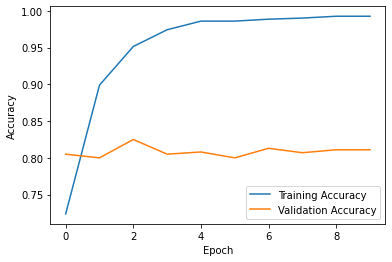

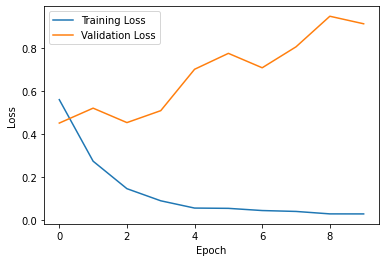

In [ ]:
plot_graph_loss(history)

              precision    recall  f1-score   support

           0       0.76      0.73      0.75       385
           1       0.84      0.85      0.84       615

    accuracy                           0.81      1000
   macro avg       0.80      0.79      0.79      1000
weighted avg       0.81      0.81      0.81      1000



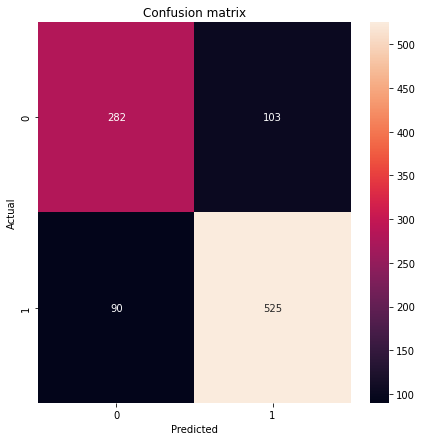

In [ ]:
predictions = lstm_model1.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

**LSTM Model 2**

In [ ]:
lstm_model2 = build_LSTM2(vocabulary_size, max_length, embedding_weights)
history = lstm_model2.fit(training_padded, y_train, epochs=100, validation_data=(validation_padded, y_dev), verbose=1)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 50, 100)           1666100   
_________________________________________________________________
dropout_3 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,683,157
Trainable params: 17,057
Non-trainable params: 1,666,100
_________________________________________________________________
Epoch 1/100
250/250 [==============================] - 5s 14ms/step - loss: 0.6452 - accuracy: 0.6401 - val_loss: 0.5099 - val_accuracy: 0.7610
Epoch 2/100
250/250 [==============================] - 3s 12ms/step - loss: 0.4672 - accuracy

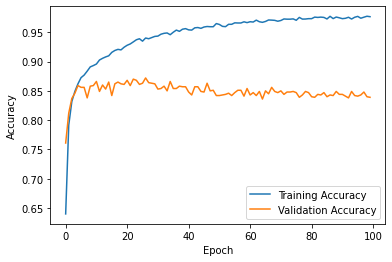

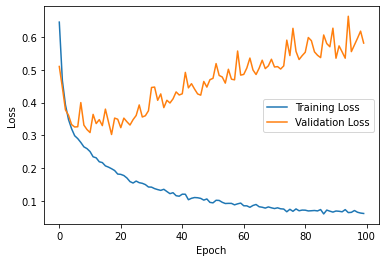

In [ ]:
plot_graph_loss(history)

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       385
           1       0.89      0.89      0.89       615

    accuracy                           0.87      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.87      0.87      0.87      1000



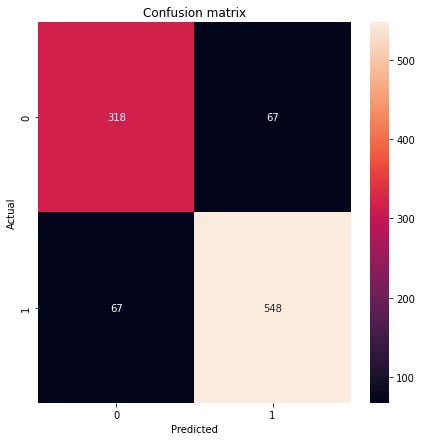

In [ ]:
predictions = lstm_model2.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

**LSTM Model 3**

In [ ]:
lstm_model3 = build_LSTM3(vocabulary_size, max_length, embedding_weights)
history = lstm_model3.fit(training_padded, y_train, epochs=20, validation_data=(validation_padded, y_dev), verbose=1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 50, 100)           1666100   
_________________________________________________________________
dropout_5 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                17024     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,683,157
Trainable params: 1,683,157
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
250/250 [==============================] - 6s 17ms/step - loss: 0.6530 - accuracy: 0.6366 - val_loss: 0.5515 - val_accuracy: 0.7330
Epoch 2/20
250/250 [==============================] - 4s 15ms/step - loss: 0.4351 - accuracy: 0.804

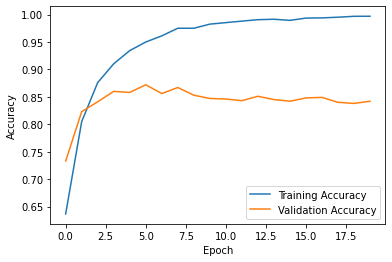

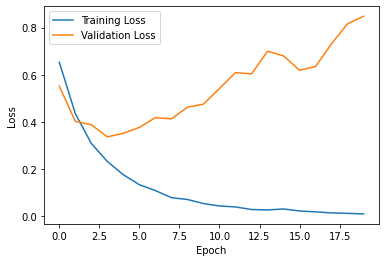

In [ ]:
plot_graph_loss(history)

              precision    recall  f1-score   support

           0       0.80      0.77      0.79       385
           1       0.86      0.88      0.87       615

    accuracy                           0.84      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.84      0.84      0.84      1000



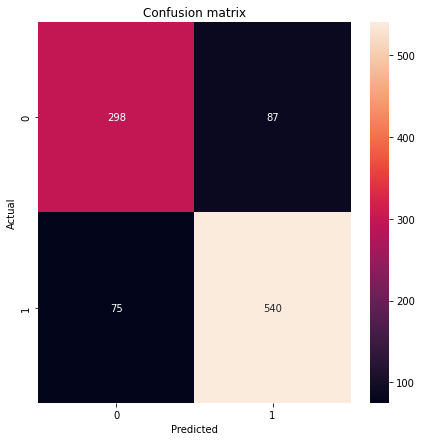

In [ ]:
predictions = lstm_model3.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

**GRU Model 1**

In [ ]:
gru_model1 = build_GRU1(vocabulary_size, max_length)
history = gru_model1.fit(training_padded, y_train, epochs=10, validation_data=(validation_padded, y_dev), verbose=1)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 100)           1666100   
_________________________________________________________________
dropout_6 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
gru (GRU)                    (None, 32)                12864     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 1,678,997
Trainable params: 1,678,997
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
250/250 [==============================] - 6s 17ms/step - loss: 0.6649 - accuracy: 0.6194 - val_loss: 0.6530 - val_accuracy: 0.6440
Epoch 2/10
250/250 [==============================] - 4s 15ms/step - loss: 0.6018 - accuracy: 0.688

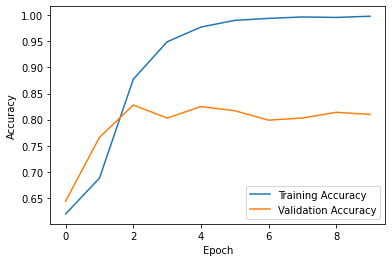

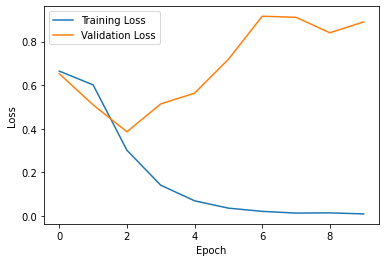

In [ ]:
plot_graph_loss(history)

              precision    recall  f1-score   support

           0       0.76      0.75      0.76       385
           1       0.85      0.85      0.85       615

    accuracy                           0.81      1000
   macro avg       0.80      0.80      0.80      1000
weighted avg       0.81      0.81      0.81      1000



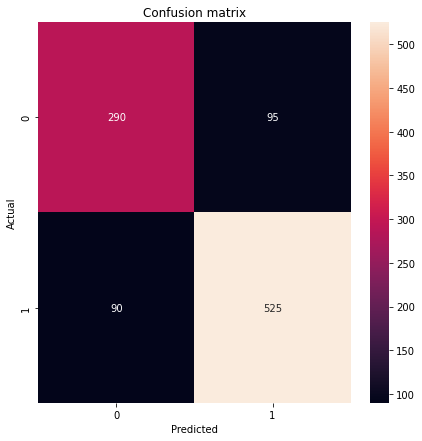

In [ ]:
predictions = gru_model1.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

**GRU Model 2**

In [ ]:
gru_model2 = build_GRU2(vocabulary_size, max_length, embedding_weights)
history = gru_model2.fit(training_padded, y_train, epochs=100, validation_data=(validation_padded, y_dev), verbose=1)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 50, 100)           1666100   
_________________________________________________________________
dropout_7 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                12864     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 1,678,997
Trainable params: 12,897
Non-trainable params: 1,666,100
_________________________________________________________________
Epoch 1/100
250/250 [==============================] - 5s 14ms/step - loss: 0.6581 - accuracy: 0.6284 - val_loss: 0.6109 - val_accuracy: 0.6590
Epoch 2/100
250/250 [==============================] - 3s 12ms/step - loss: 0.4640 - accuracy

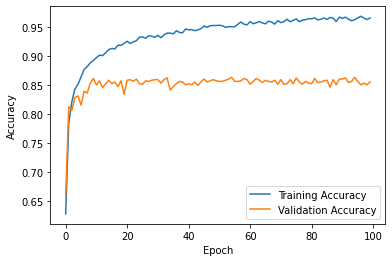

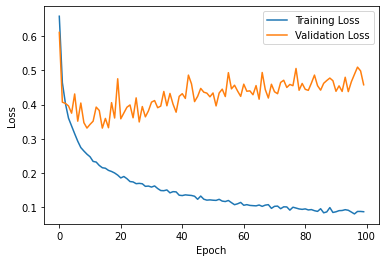

In [ ]:
plot_graph_loss(history)

              precision    recall  f1-score   support

           0       0.84      0.81      0.83       385
           1       0.89      0.91      0.90       615

    accuracy                           0.87      1000
   macro avg       0.86      0.86      0.86      1000
weighted avg       0.87      0.87      0.87      1000



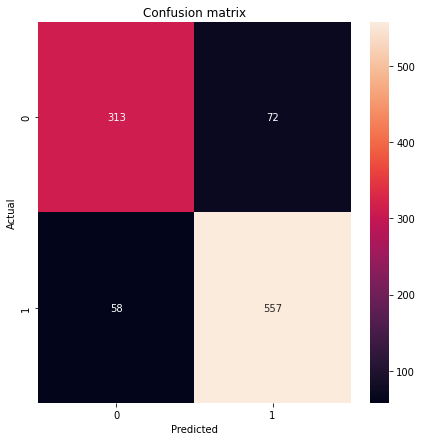

In [ ]:
predictions = gru_model2.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

**GRU Model 3**

In [ ]:
gru_model3 = build_GRU3(vocabulary_size, max_length, embedding_weights)
history = gru_model3.fit(training_padded, y_train, epochs=10, validation_data=(validation_padded, y_dev), verbose=1)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 50, 100)           1666100   
_________________________________________________________________
dropout_8 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                12864     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 1,678,997
Trainable params: 1,678,997
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
250/250 [==============================] - 6s 19ms/step - loss: 0.6532 - accuracy: 0.6275 - val_loss: 0.5744 - val_accuracy: 0.7080
Epoch 2/10
250/250 [==============================] - 4s 15ms/step - loss: 0.4413 - accuracy: 0.802

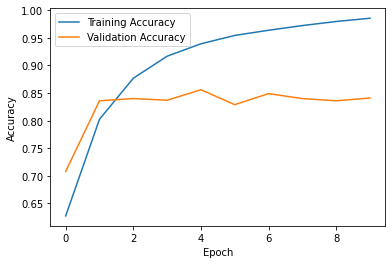

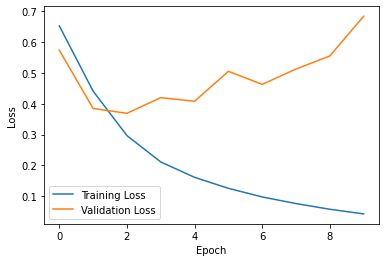

In [ ]:
plot_graph_loss(history)

              precision    recall  f1-score   support

           0       0.83      0.75      0.79       385
           1       0.85      0.91      0.88       615

    accuracy                           0.84      1000
   macro avg       0.84      0.83      0.83      1000
weighted avg       0.84      0.84      0.84      1000



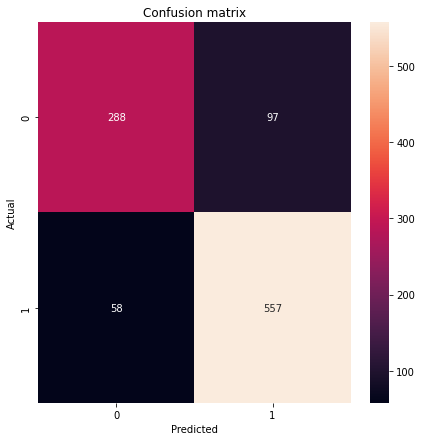

In [ ]:
predictions = gru_model3.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

**Bidirectional LSTM**

In [ ]:
bi_lstm = build_bidirectional_LSTM(vocabulary_size, max_length, embedding_weights)
history = bi_lstm.fit(training_padded, y_train, epochs=10, validation_data=(validation_padded, y_dev), verbose=1)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 100)           1666100   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 64)            34048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 1,725,045
Trainable params: 1,725,045
Non-trainable params: 0
____________________________________________

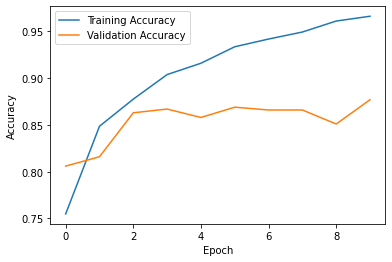

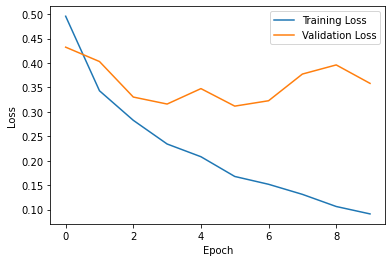

In [ ]:
plot_graph_loss(history)

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       385
           1       0.90      0.89      0.90       615

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



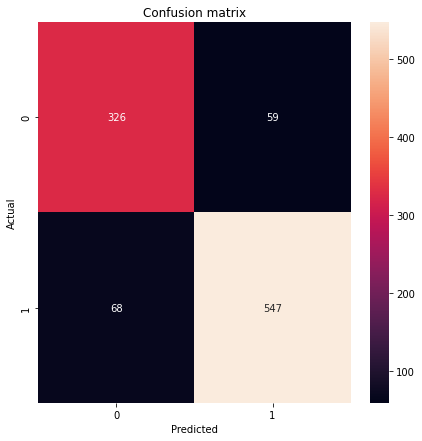

In [ ]:
predictions = bi_lstm.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

**Bidirectional GRU**

In [ ]:
bi_gru = build_bidirectional_GRU(vocabulary_size, max_length, embedding_weights)
history = bi_gru.fit(training_padded, y_train, epochs=10, validation_data=(validation_padded, y_dev), verbose=1)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 50, 100)           1666100   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 100)           0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 64)            25728     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                18816     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 1,710,709
Trainable params: 1,710,709
Non-trainable params: 0
___________________________________________

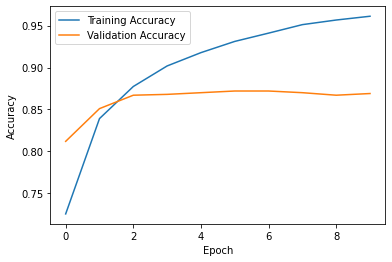

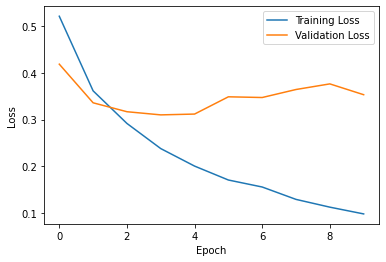

In [ ]:
plot_graph_loss(history)

              precision    recall  f1-score   support

           0       0.78      0.86      0.82       385
           1       0.91      0.85      0.88       615

    accuracy                           0.85      1000
   macro avg       0.85      0.86      0.85      1000
weighted avg       0.86      0.85      0.86      1000



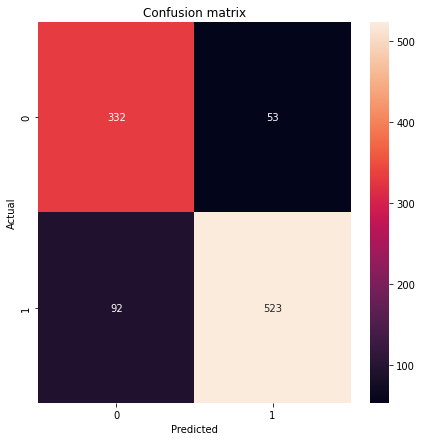

In [ ]:
predictions = bi_gru.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

**CNN Model**

In [ ]:
cnn = build_CNN(vocabulary_size, max_length, embedding_weights)
history = cnn.fit(training_padded, y_train, epochs=10, validation_data=(validation_padded, y_dev), verbose=1)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 50, 100)           1666100   
_________________________________________________________________
conv1d (Conv1D)              (None, 46, 32)            16032     
_________________________________________________________________
dropout_11 (Dropout)         (None, 46, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 44, 16)            1552      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 14, 16)            0         
_________________________________________________________________
flatten (Flatten)            (None, 224)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)               

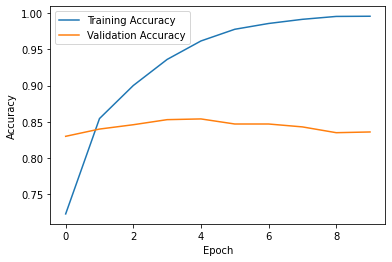

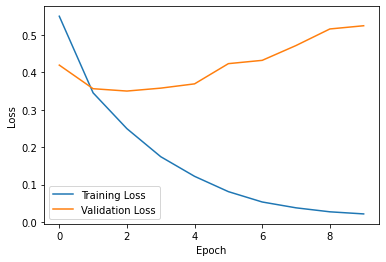

In [ ]:
plot_graph_loss(history)

              precision    recall  f1-score   support

           0       0.77      0.78      0.78       385
           1       0.86      0.85      0.86       615

    accuracy                           0.83      1000
   macro avg       0.82      0.82      0.82      1000
weighted avg       0.83      0.83      0.83      1000



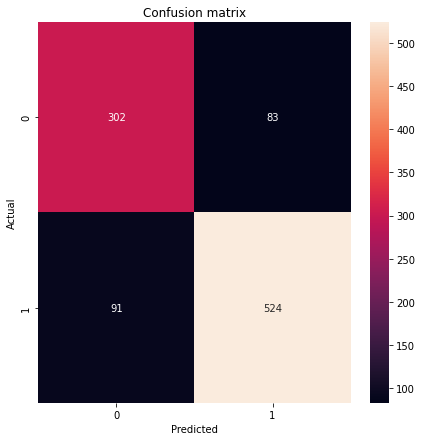

In [ ]:
predictions = cnn.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

**LSTM CNN Model**

In [ ]:
lstm_cnn = build_LSTM_CNN(vocabulary_size, max_length, embedding_weights)
history = lstm_cnn.fit(training_padded, y_train, epochs=20, validation_data=(validation_padded, y_dev), verbose=1)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 50, 100)           1666100   
_________________________________________________________________
dropout_14 (Dropout)         (None, 50, 100)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 50, 128)           84480     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 48, 64)            24640     
_________________________________________________________________
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 3073      
Total params: 1,778,293
Trainable params: 1,778,293
Non-trainable params: 0
___________________________________________

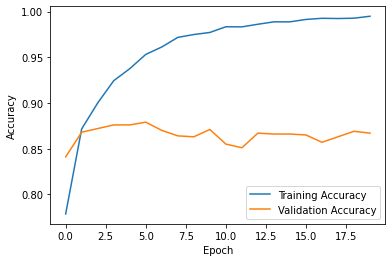

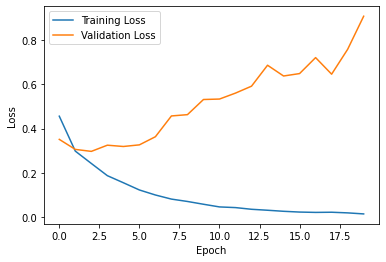

In [ ]:
plot_graph_loss(history)

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       385
           1       0.88      0.93      0.91       615

    accuracy                           0.88      1000
   macro avg       0.88      0.87      0.87      1000
weighted avg       0.88      0.88      0.88      1000



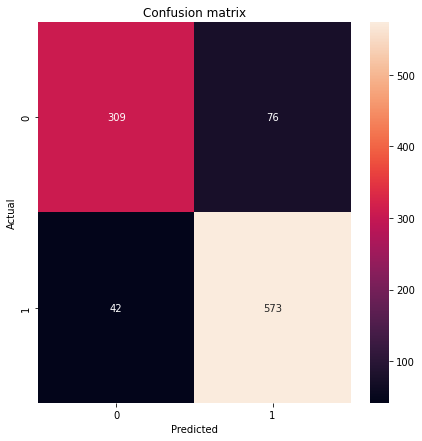

In [ ]:
predictions = lstm_cnn.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

**CNN LSTM Model**

In [ ]:
cnn_lstm = build_CNN_LSTM(vocabulary_size, max_length, embedding_weights)
history = cnn_lstm.fit(training_padded, y_train, epochs=20, validation_data=(validation_padded, y_dev), verbose=1)

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 50, 100)           1666100   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 50, 100)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 47, 64)            25664     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 11, 64)            0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 65        
Total params: 1,716,661
Trainable params: 1,716,661
Non-trainable params: 0
___________________________________________

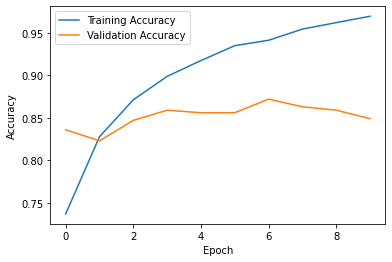

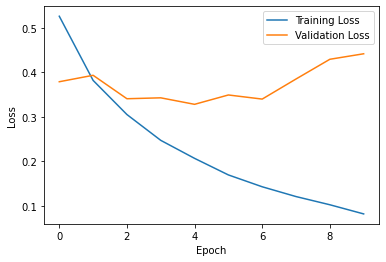

In [ ]:
plot_graph_loss(history)

              precision    recall  f1-score   support

           0       0.82      0.81      0.81       385
           1       0.88      0.89      0.89       615

    accuracy                           0.86      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.86      0.86      0.86      1000



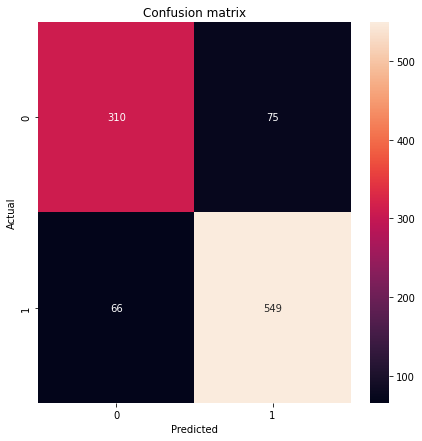

In [ ]:
predictions = cnn_lstm.predict(testing_padded)
predictions = predictions.flatten()
predictions = np.where(predictions >= 0.5, 1, 0)
calculate_metrics_classification(y_test, predictions)

**BERT Model**

In [ ]:
text_train = list(X_train)
text_val = list(X_dev)
text_test = list(X_test)

In [ ]:
bert_tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
train_encodings = bert_tokenizer(text_train, max_length=100, truncation=True, padding="max_length", return_tensors='tf')
val_encodings = bert_tokenizer(text_val, max_length=100, truncation=True, padding="max_length", return_tensors='tf')
test_encodings = bert_tokenizer(text_test, max_length=100, truncation=True, padding="max_length", return_tensors='tf')

In [ ]:
print(np.shape(train_encodings["input_ids"]))
print(np.shape(val_encodings["input_ids"]))
print(np.shape(test_encodings["input_ids"]))

(8000, 100)
(1000, 100)
(1000, 100)


In [ ]:
def bert_model(input_shape):
    model = TFBertModel.from_pretrained('bert-base-uncased')
    layer = model.layers[0]

    inputs = keras.Input(shape=input_shape, dtype='int32')
    input_masks = keras.Input(shape=input_shape, dtype='int32')

    outputs = layer([inputs, input_masks])
    output = outputs[0]
    pooled_output = output[:, 0, :] 

    is_humor = layers.Dropout(0.3)(pooled_output)
    is_humor = layers.Dense(32, activation="relu")(is_humor)
    is_humor = layers.Dense(1, activation="sigmoid")(is_humor)

    model = keras.Model(inputs=[inputs, input_masks], outputs=is_humor)    
    return model

In [ ]:
model = bert_model((100,))
optimizer = keras.optimizers.Adam(learning_rate=2e-5)
loss_fun = [tf.keras.losses.BinaryCrossentropy(from_logits=False)]
metric = [
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]
model.compile(optimizer=optimizer, loss=loss_fun, metrics=metric)
model.summary()

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109482240   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           bert[0][0]                   

In [ ]:
history = model.fit(x = [train_encodings["input_ids"], train_encodings["attention_mask"]], y = y_train,
    validation_data = ([val_encodings["input_ids"], val_encodings["attention_mask"]], y_dev),
    batch_size=16, shuffle=True, epochs=3)

Epoch 1/3
500/500 [==============================] - 343s 663ms/step - loss: 0.2645 - binary_accuracy: 0.8913 - precision_2: 0.9030 - recall_2: 0.9227 - val_loss: 0.2929 - val_binary_accuracy: 0.8880 - val_precision_2: 0.8779 - val_recall_2: 0.9557
Epoch 2/3
500/500 [==============================] - 327s 655ms/step - loss: 0.0975 - binary_accuracy: 0.9669 - precision_2: 0.9740 - recall_2: 0.9722 - val_loss: 0.4085 - val_binary_accuracy: 0.8730 - val_precision_2: 0.8541 - val_recall_2: 0.9636
Epoch 3/3
500/500 [==============================] - 327s 655ms/step - loss: 0.0355 - binary_accuracy: 0.9868 - precision_2: 0.9897 - recall_2: 0.9888 - val_loss: 0.4587 - val_binary_accuracy: 0.8860 - val_precision_2: 0.8765 - val_recall_2: 0.9541


              precision    recall  f1-score   support

           0       0.90      0.84      0.87       385
           1       0.90      0.94      0.92       615

    accuracy                           0.90      1000
   macro avg       0.90      0.89      0.90      1000
weighted avg       0.90      0.90      0.90      1000



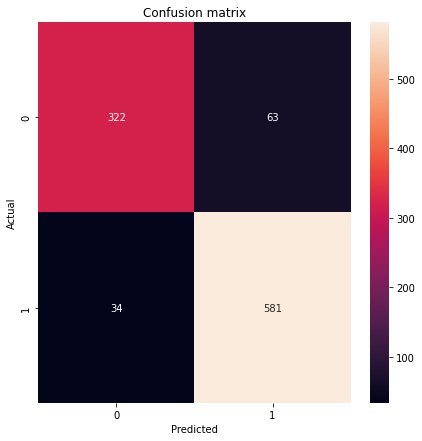

In [ ]:
predictions = model.predict([test_encodings["input_ids"], test_encodings["attention_mask"]])
predictions = np.round(predictions)
predictions = np.squeeze(predictions, axis=-1)
calculate_metrics_classification(y_test, predictions)

In [ ]:
def bert_model2(input_shape):
    model = TFBertModel.from_pretrained('bert-base-uncased')
    layer = model.layers[0]

    inputs = keras.Input(shape=input_shape, dtype='int32')
    input_masks = keras.Input(shape=input_shape, dtype='int32')

    outputs = layer([inputs, input_masks])
    output = outputs[0]
    pooled_output = output[:, 0, :] 

    is_humor = layers.Dense(64, activation='relu')(pooled_output)
    is_humor = layers.Dropout(0.3)(is_humor)
    is_humor = layers.Dense(32, activation='relu')(is_humor)
    is_humor = layers.Dense(1, activation="sigmoid")(is_humor)

    model = keras.Model(inputs=[inputs, input_masks], outputs=is_humor)    
    return model

In [ ]:
model = bert_model2((100,))
optimizer = keras.optimizers.Adam(learning_rate=2e-5)
loss_fun = [tf.keras.losses.BinaryCrossentropy(from_logits=False)]
metric = [
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]
model.compile(optimizer=optimizer, loss=loss_fun, metrics=metric)
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 109482240   input_17[0][0]                   
                                                                 input_18[0][0]                   
__________________________________________________________________________________________________
tf.__operators__.getitem_7 (Sli (None, 768)          0           bert[0][0]                 

In [ ]:
history = model.fit(x = [train_encodings["input_ids"], train_encodings["attention_mask"]], y = y_train,
    validation_data = ([val_encodings["input_ids"], val_encodings["attention_mask"]], y_dev),
    batch_size=16, shuffle=True, epochs=3)

Epoch 1/3
500/500 [==============================] - 353s 682ms/step - loss: 0.2934 - binary_accuracy: 0.8794 - precision_3: 0.8875 - recall_3: 0.9211 - val_loss: 0.3280 - val_binary_accuracy: 0.8630 - val_precision_3: 0.8634 - val_recall_3: 0.9304
Epoch 2/3
500/500 [==============================] - 337s 674ms/step - loss: 0.1188 - binary_accuracy: 0.9619 - precision_3: 0.9696 - recall_3: 0.9686 - val_loss: 0.4125 - val_binary_accuracy: 0.8610 - val_precision_3: 0.8834 - val_recall_3: 0.8987
Epoch 3/3
500/500 [==============================] - 338s 675ms/step - loss: 0.0643 - binary_accuracy: 0.9801 - precision_3: 0.9842 - recall_3: 0.9836 - val_loss: 0.3841 - val_binary_accuracy: 0.8770 - val_precision_3: 0.8759 - val_recall_3: 0.9383


              precision    recall  f1-score   support

           0       0.91      0.86      0.88       385
           1       0.91      0.95      0.93       615

    accuracy                           0.91      1000
   macro avg       0.91      0.90      0.91      1000
weighted avg       0.91      0.91      0.91      1000



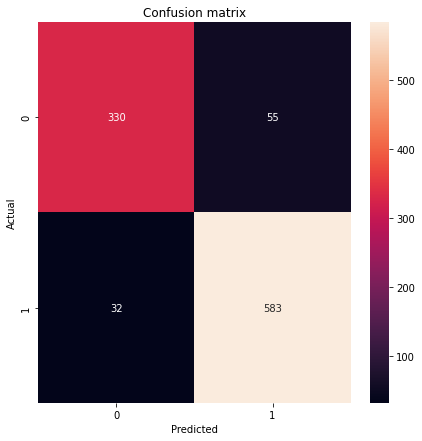

In [ ]:
predictions = model.predict([test_encodings["input_ids"], test_encodings["attention_mask"]])
predictions = np.round(predictions)
predictions = np.squeeze(predictions, axis=-1)
calculate_metrics_classification(y_test, predictions)

**ALBERT Model**

In [ ]:
albert_tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')

Downloading:   0%|          | 0.00/760k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/684 [00:00<?, ?B/s]

In [ ]:
train_encodings = albert_tokenizer(text_train, max_length=100, truncation=True, padding="max_length", return_tensors='tf')
val_encodings = albert_tokenizer(text_val, max_length=100, truncation=True, padding="max_length", return_tensors='tf')
test_encodings = albert_tokenizer(text_test, max_length=100, truncation=True, padding="max_length", return_tensors='tf')

In [ ]:
def albert_model(input_shape):
    model = TFAlbertModel.from_pretrained('albert-base-v2')
    layer = model.layers[0]

    inputs = keras.Input(shape=input_shape, dtype='int32')
    input_masks = keras.Input(shape=input_shape, dtype='int32')

    outputs = layer([inputs, input_masks])
    output = outputs[0]
    pooled_output = output[:, 0, :] 

    is_humor = layers.Dropout(0.3)(pooled_output)
    is_humor = layers.Dense(32, activation="relu")(is_humor)
    is_humor = layers.Dense(1, activation="sigmoid")(is_humor)

    model = keras.Model(inputs=[inputs, input_masks], outputs=is_humor)    
    return model

In [ ]:
model = albert_model((100,))
optimizer = keras.optimizers.Adam(learning_rate=2e-5)
loss_fun = [tf.keras.losses.BinaryCrossentropy(from_logits=False)]
metric = [
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]
model.compile(optimizer=optimizer, loss=loss_fun, metrics=metric)
model.summary()

Downloading:   0%|          | 0.00/63.0M [00:00<?, ?B/s]

Some layers from the model checkpoint at albert-base-v2 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-base-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_20 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
albert (TFAlbertMainLayer)      TFBaseModelOutputWit 11683584    input_19[0][0]                   
                                                                 input_20[0][0]                   
__________________________________________________________________________________________________
tf.__operators__.getitem_8 (Sli (None, 768)          0           albert[0][0]               

In [ ]:
history = model.fit(x = [train_encodings["input_ids"], train_encodings["attention_mask"]], y = y_train,
    validation_data = ([val_encodings["input_ids"], val_encodings["attention_mask"]], y_dev),
    batch_size=16, shuffle=True, epochs=3)

Epoch 1/3
500/500 [==============================] - 335s 651ms/step - loss: 0.3051 - binary_accuracy: 0.8742 - precision_4: 0.8896 - recall_4: 0.9088 - val_loss: 0.4127 - val_binary_accuracy: 0.8230 - val_precision_4: 0.7951 - val_recall_4: 0.9699
Epoch 2/3
500/500 [==============================] - 322s 645ms/step - loss: 0.1610 - binary_accuracy: 0.9410 - precision_4: 0.9529 - recall_4: 0.9513 - val_loss: 0.3755 - val_binary_accuracy: 0.8570 - val_precision_4: 0.8612 - val_recall_4: 0.9225
Epoch 3/3
500/500 [==============================] - 323s 645ms/step - loss: 0.1106 - binary_accuracy: 0.9582 - precision_4: 0.9663 - recall_4: 0.9659 - val_loss: 0.4348 - val_binary_accuracy: 0.8460 - val_precision_4: 0.8283 - val_recall_4: 0.9541


              precision    recall  f1-score   support

           0       0.94      0.76      0.84       385
           1       0.87      0.97      0.92       615

    accuracy                           0.89      1000
   macro avg       0.90      0.87      0.88      1000
weighted avg       0.90      0.89      0.89      1000



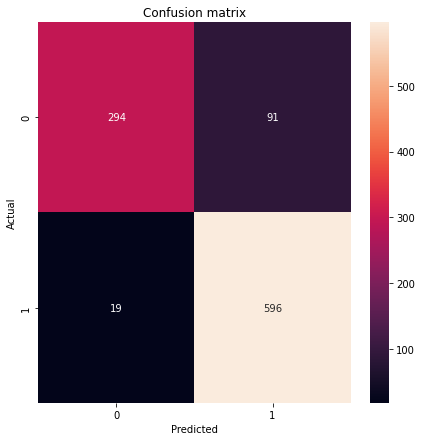

In [ ]:
predictions = model.predict([test_encodings["input_ids"], test_encodings["attention_mask"]])
predictions = np.round(predictions)
predictions = np.squeeze(predictions, axis=-1)
calculate_metrics_classification(y_test, predictions)

In [ ]:
def albert_model2(input_shape):
    model = TFAlbertModel.from_pretrained('albert-base-v2')
    layer = model.layers[0]

    inputs = keras.Input(shape=input_shape, dtype='int32')
    input_masks = keras.Input(shape=input_shape, dtype='int32')

    outputs = layer([inputs, input_masks])
    output = outputs[0]
    pooled_output = output[:, 0, :] 

    is_humor = layers.Dense(64, activation='relu')(pooled_output)
    is_humor = layers.Dropout(0.3)(is_humor)
    is_humor = layers.Dense(32, activation='relu')(is_humor)
    is_humor = layers.Dense(1, activation="sigmoid")(is_humor)

    model = keras.Model(inputs=[inputs, input_masks], outputs=is_humor)    
    return model

In [ ]:
model = albert_model2((100,))
optimizer = keras.optimizers.Adam(learning_rate=2e-5)
loss_fun = [tf.keras.losses.BinaryCrossentropy(from_logits=False)]
metric = [
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]
model.compile(optimizer=optimizer, loss=loss_fun, metrics=metric)
model.summary()

Some layers from the model checkpoint at albert-base-v2 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-base-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           [(None, 100)]        0                                            
__________________________________________________________________________________________________
albert (TFAlbertMainLayer)      TFBaseModelOutputWit 11683584    input_21[0][0]                   
                                                                 input_22[0][0]                   
__________________________________________________________________________________________________
tf.__operators__.getitem_9 (Sli (None, 768)          0           albert[0][0]               

In [ ]:
history = model.fit(x = [train_encodings["input_ids"], train_encodings["attention_mask"]], y = y_train,
    validation_data = ([val_encodings["input_ids"], val_encodings["attention_mask"]], y_dev),
    batch_size=16, shuffle=True, epochs=3)

Epoch 1/3
500/500 [==============================] - 336s 653ms/step - loss: 0.3104 - binary_accuracy: 0.8783 - precision_5: 0.8952 - recall_5: 0.9090 - val_loss: 0.3118 - val_binary_accuracy: 0.8630 - val_precision_5: 0.8837 - val_recall_5: 0.9019
Epoch 2/3
500/500 [==============================] - 323s 645ms/step - loss: 0.1836 - binary_accuracy: 0.9335 - precision_5: 0.9508 - recall_5: 0.9408 - val_loss: 0.3630 - val_binary_accuracy: 0.8470 - val_precision_5: 0.8668 - val_recall_5: 0.8956
Epoch 3/3
500/500 [==============================] - 322s 645ms/step - loss: 0.1167 - binary_accuracy: 0.9604 - precision_5: 0.9691 - recall_5: 0.9665 - val_loss: 0.3314 - val_binary_accuracy: 0.8670 - val_precision_5: 0.8559 - val_recall_5: 0.9494


              precision    recall  f1-score   support

           0       0.90      0.80      0.84       385
           1       0.88      0.94      0.91       615

    accuracy                           0.89      1000
   macro avg       0.89      0.87      0.88      1000
weighted avg       0.89      0.89      0.88      1000



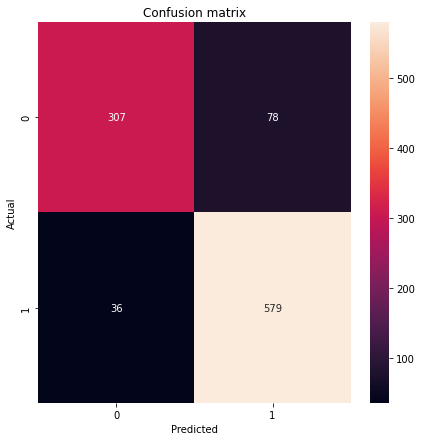

In [ ]:
predictions = model.predict([test_encodings["input_ids"], test_encodings["attention_mask"]])
predictions = np.round(predictions)
predictions = np.squeeze(predictions, axis=-1)
calculate_metrics_classification(y_test, predictions)

**RoBERTa Model**

In [ ]:
roberta_tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [ ]:
train_encodings = roberta_tokenizer(text_train, max_length=100, truncation=True, padding="max_length", return_tensors='tf')
val_encodings = roberta_tokenizer(text_val, max_length=100, truncation=True, padding="max_length", return_tensors='tf')
test_encodings = roberta_tokenizer(text_test, max_length=100, truncation=True, padding="max_length", return_tensors='tf')

In [ ]:
def roberta_model(input_shape):
    model = TFRobertaModel.from_pretrained('roberta-base')
    layer = model.layers[0]

    inputs = keras.Input(shape=input_shape, dtype='int32')
    input_masks = keras.Input(shape=input_shape, dtype='int32')

    outputs = layer([inputs, input_masks])
    output = outputs[0]
    pooled_output = output[:, 0, :] 

    is_humor = layers.Dropout(0.3)(pooled_output)
    is_humor = layers.Dense(32, activation="relu")(is_humor)
    is_humor = layers.Dense(1, activation="sigmoid")(is_humor)

    model = keras.Model(inputs=[inputs, input_masks], outputs=is_humor)    
    return model

In [ ]:
model = roberta_model((100,))
optimizer = keras.optimizers.Adam(learning_rate=2e-5)
loss_fun = [tf.keras.losses.BinaryCrossentropy(from_logits=False)]
metric = [
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]
model.compile(optimizer=optimizer, loss=loss_fun, metrics=metric)
model.summary()

Downloading:   0%|          | 0.00/657M [00:00<?, ?B/s]

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
roberta (TFRobertaMainLayer)    TFBaseModelOutputWit 124645632   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem (Slici (None, 768)          0           roberta[0][0]                

In [ ]:
history = model.fit(x = [train_encodings["input_ids"], train_encodings["attention_mask"]], y = y_train,
    validation_data = ([val_encodings["input_ids"], val_encodings["attention_mask"]], y_dev),
    batch_size=16, shuffle=True, epochs=3)

Epoch 1/3
500/500 [==============================] - 344s 665ms/step - loss: 0.2768 - binary_accuracy: 0.8815 - precision: 0.8907 - recall: 0.9207 - val_loss: 0.2745 - val_binary_accuracy: 0.8830 - val_precision: 0.9107 - val_recall: 0.9035
Epoch 2/3
500/500 [==============================] - 329s 658ms/step - loss: 0.1325 - binary_accuracy: 0.9509 - precision: 0.9580 - recall: 0.9625 - val_loss: 0.3670 - val_binary_accuracy: 0.8800 - val_precision: 0.8647 - val_recall: 0.9604
Epoch 3/3
500/500 [==============================] - 329s 658ms/step - loss: 0.0766 - binary_accuracy: 0.9749 - precision: 0.9787 - recall: 0.9805 - val_loss: 0.4184 - val_binary_accuracy: 0.8470 - val_precision: 0.8285 - val_recall: 0.9557


              precision    recall  f1-score   support

           0       0.97      0.76      0.85       385
           1       0.87      0.98      0.92       615

    accuracy                           0.90      1000
   macro avg       0.92      0.87      0.89      1000
weighted avg       0.91      0.90      0.90      1000



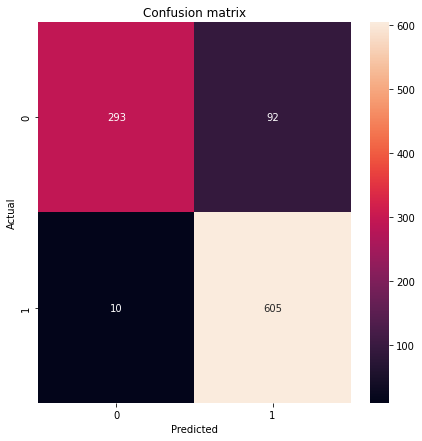

In [ ]:
predictions = model.predict([test_encodings["input_ids"], test_encodings["attention_mask"]])
predictions = np.round(predictions)
predictions = np.squeeze(predictions, axis=-1)
calculate_metrics_classification(y_test, predictions)

In [ ]:
def roberta_model2(input_shape):
    model = TFRobertaModel.from_pretrained('roberta-base')
    layer = model.layers[0]

    inputs = keras.Input(shape=input_shape, dtype='int32')
    input_masks = keras.Input(shape=input_shape, dtype='int32')

    outputs = layer([inputs, input_masks])
    output = outputs[0]
    pooled_output = output[:, 0, :] 

    is_humor = layers.Dense(64, activation='relu')(pooled_output)
    is_humor = layers.Dropout(0.3)(is_humor)
    is_humor = layers.Dense(32, activation="relu")(is_humor)
    is_humor = layers.Dense(1, activation="sigmoid")(is_humor)

    model = keras.Model(inputs=[inputs, input_masks], outputs=is_humor)    
    return model

In [ ]:
model = roberta_model2((100,))
optimizer = keras.optimizers.Adam(learning_rate=2e-5)
loss_fun = [tf.keras.losses.BinaryCrossentropy(from_logits=False)]
metric = [
    tf.keras.metrics.BinaryAccuracy(),
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]
model.compile(optimizer=optimizer, loss=loss_fun, metrics=metric)
model.summary()

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
roberta (TFRobertaMainLayer)    TFBaseModelOutputWit 124645632   input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli (None, 768)          0           roberta[0][0]              

In [ ]:
history = model.fit(x = [train_encodings["input_ids"], train_encodings["attention_mask"]], y = y_train,
    validation_data = ([val_encodings["input_ids"], val_encodings["attention_mask"]], y_dev),
    batch_size=16, shuffle=True, epochs=3)

Epoch 1/3
500/500 [==============================] - 348s 672ms/step - loss: 0.3000 - binary_accuracy: 0.8714 - precision_1: 0.8755 - recall_1: 0.9225 - val_loss: 0.3352 - val_binary_accuracy: 0.8620 - val_precision_1: 0.8559 - val_recall_1: 0.9399
Epoch 2/3
500/500 [==============================] - 331s 662ms/step - loss: 0.1523 - binary_accuracy: 0.9442 - precision_1: 0.9555 - recall_1: 0.9540 - val_loss: 0.3819 - val_binary_accuracy: 0.8810 - val_precision_1: 0.8755 - val_recall_1: 0.9462
Epoch 3/3
500/500 [==============================] - 331s 663ms/step - loss: 0.0823 - binary_accuracy: 0.9737 - precision_1: 0.9775 - recall_1: 0.9799 - val_loss: 0.5218 - val_binary_accuracy: 0.8750 - val_precision_1: 0.8526 - val_recall_1: 0.9699


              precision    recall  f1-score   support

           0       0.96      0.77      0.86       385
           1       0.87      0.98      0.92       615

    accuracy                           0.90      1000
   macro avg       0.92      0.88      0.89      1000
weighted avg       0.91      0.90      0.90      1000



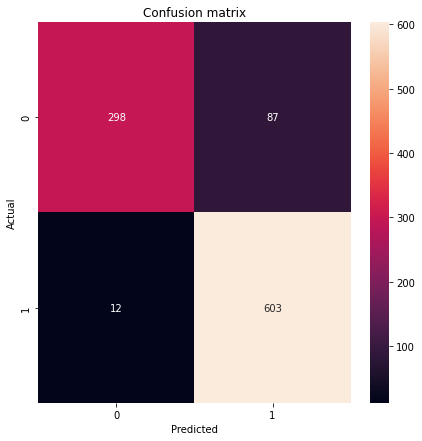

In [ ]:
predictions = model.predict([test_encodings["input_ids"], test_encodings["attention_mask"]])
predictions = np.round(predictions)
predictions = np.squeeze(predictions, axis=-1)
calculate_metrics_classification(y_test, predictions)